In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB


from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

from classifier.detector_classifier import DetectorClassifier
from evaluation.prequential import prequential

In [2]:
def read_data(filename):
    df = pd.read_csv(filename)
    data = df.values
    return data[:, :-1], data[:, -1]


GaussianNB:
Mean acc within the window 1000: 0.7289912189511405

Page-Hinkley:
Drift detection: 20
Mean acc within the window 1000: 0.7508117493530342

AdWin:
Drift detection: 38
Mean acc within the window 1000: 0.7496407953816554


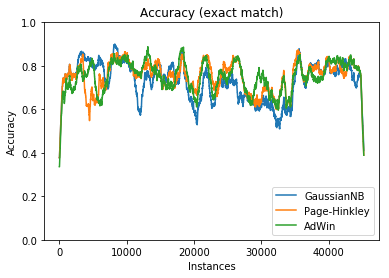

In [3]:
if __name__ == '__main__':
    n_train = 100
    X, y = read_data("data/elecNormNew.csv")
    # Set x,y as numeric
    X = X.astype(float)
    label = ["UP", "DOWN"]
    
    le = preprocessing.LabelEncoder()
    le.fit(label)
    y = le.transform(y)

    w = 1000

    clfs = [
        GaussianNB(),
        DetectorClassifier(GaussianNB(), PageHinkley(), np.unique(y)),
        DetectorClassifier(GaussianNB(), ADWIN(), np.unique(y))
    ]
    clfs_label = ["GaussianNB", "Page-Hinkley", "AdWin"]

    plt.title("Accuracy (exact match)")
    plt.xlabel("Instances")
    plt.ylabel("Accuracy")

    for i in range(len(clfs)):
        print("\n{}:".format(clfs_label[i]))
        with np.errstate(divide='ignore', invalid='ignore'):
            y_pre, time = prequential(X, y, clfs[i], n_train)
        if clfs[i].__class__.__name__ == "DetectorClassifier":
            print("Drift detection: {}".format(clfs[i].change_detected))
        estimator = (y[n_train:] == y_pre) * 1

        acc_run = np.convolve(estimator, np.ones((w,)) / w, 'same')
        print("Mean acc within the window {}: {}".format(w, np.mean(acc_run)))
        plt.plot(acc_run, "-", label=clfs_label[i])

    plt.legend(loc='lower right')
    plt.ylim([0, 1])
    plt.show()